# Anticipez le retard de vol des avions - Analyse exploratoire

## Introduction

Pour ce problème, nous nous intéressons au retard de vols d'avions. La database fournie nous provient d'un site américain de statistiques : https://www.transtats.bts.gov/. Cette base de données recense plus de 5 millions de vols qui ont eu lieu pendant l'année 2016. Nous allons dans cette partie préparer les données afin dans une seconde partie de tester plusieurs algorithmes pour prédire le retard potentiel de ces avions

## Les données

Nous récupérons donc les données à partie de la base de donnée fournie:

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1K1wQwErVE2WWRtpBkYZ6zdlOyCNxEu-E'}) # replace the id with id of file you want to access
downloaded.GetContentFile('2016_exploration.csv')  

In [0]:
#3. Read file as panda dataframe
import pandas as pd
dataset = pd.read_csv('2016_exploration.csv', low_memory=False)

Nous avons 5 635 978 vols pour 65 variables.

## Analyse exploratoire

Nous allons essayer de faire une brêve étude exploratoire pour mieux comprendre notre base de données.

Il est tout de suite intéressant de regarder la distribution des retards de manière générale.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5af0921780>]],
      dtype=object)

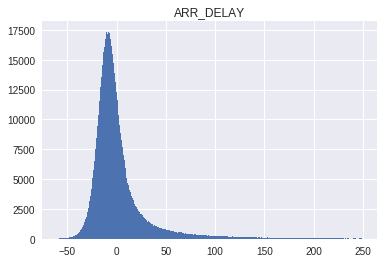

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
ARR_DELAY = dataset[['ARR_DELAY']]
bins = np.arange(-60,250,1)
ARR_DELAY.hist(bins = bins)

On observe une distribution qui semble aléatoire et suivre une distribution normale avec une moyenne de -9 mins d'attente à l'arrivée!

On peut observer également le type de distance qui existe dans notre dataset.

[]

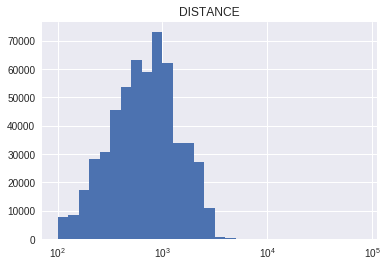

In [5]:
DISTANCE = dataset[['DISTANCE']]
bins = 10**(np.arange(2,5,0.1))
DISTANCE.hist(bins=bins)
plt.semilogx()

La moyenne est de 844 kms. On voit qu'approximativement toutes les distances sont représentés de 100km à approximativement 1000km. Les distances à plus de 1000km sont moins représentés.

### Compagnie aérienne

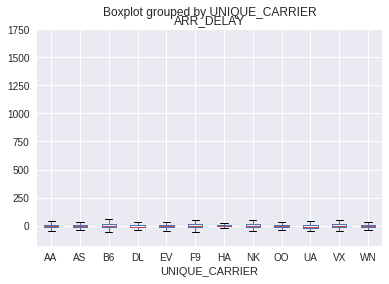

In [6]:
dataset.boxplot(column='ARR_DELAY', by='UNIQUE_CARRIER')

On ne remarque pas grand chose du à la présence de quelques retard importants qui faussent notre échelle.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


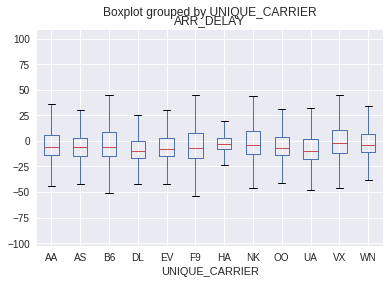

In [7]:
d = dataset[dataset['ARR_DELAY'].values<100]
d.boxplot(column='ARR_DELAY', by='UNIQUE_CARRIER')

On remarque que certaines compagnies aériennes ont tendances à avoir des vols qvec des retards. Cependant on peut également remarquer qu'aucune des compagnies aériennes à un retard supérieur à 0.

### Retards importants

On a vu dans l'étude précédente qu'il existe des vols avec des retard importants. Nous allons simplement prendre comme définition de retards importants, les vols avec un retard de plus de deux heures.

In [8]:
d = dataset[dataset['ARR_DELAY'].values>120]
print(len(d)/len(dataset))

0.019804798047624722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Ces retards représentent moins de 2% de notre dataset. On pourrait essayer d'analyser les raisons des retards importants. Cependant comme certains des retards sont dues à des conditions exceptionnels, on va simplement les supprimés car on ne pourra pas les prédire avec les informations contenues dans notre dataset.

In [3]:
dataset = dataset[dataset['ARR_DELAY'].values<=120]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


On peut maintenant retourné a notre ànalyse exploratoire.

### Retard en fonction du jour de la semaine

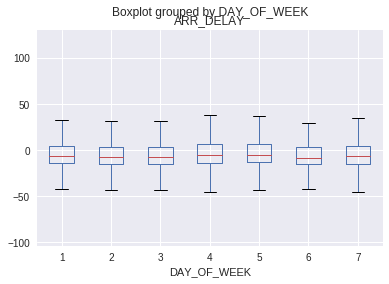

In [10]:
dataset.boxplot(column='ARR_DELAY', by='DAY_OF_WEEK')

On ne voit pas grand chose ici: les distributions des retards sont à peu près équivalentes. On peut simplement regarder la moyenne par jour de la semaine

Text(0,0.5,'Retard moyen')

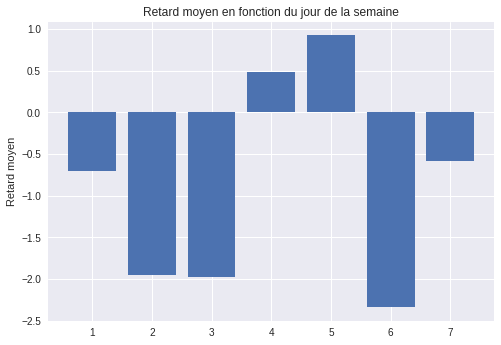

In [10]:
import matplotlib.pyplot as plt
import numpy as np
means=[]
for i in range(1,8):
    means.append(dataset[['ARR_DELAY']][dataset['DAY_OF_WEEK'] == i].mean())
means = np.array(means).astype(float).reshape((7,))
plt.bar(np.array(range(1,8)), means)
plt.title('Retard moyen en fonction du jour de la semaine')
plt.ylabel('Retard moyen')

On voit que les retards les plus importants sont le vendredi, le dimanche et le lundi.

### Retard par mois

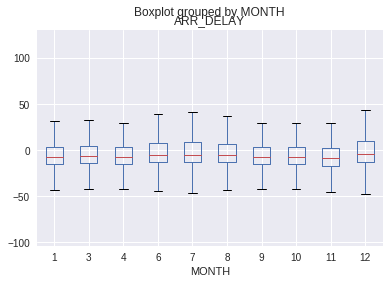

In [12]:
dataset.boxplot(column='ARR_DELAY', by='MONTH')

Ici, on peut remarquer que les distributions sont à peu près identiques, on remarque quand même que les retards sont plus en retard pendant les mois de juin, juillet, août mais surtout décembre. 

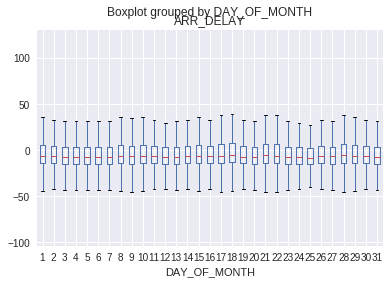

In [13]:
dataset.boxplot(column='ARR_DELAY', by='DAY_OF_MONTH')

### Retard en fonction des aéroports

On va simplement ici regarder les moyennes des retards des aéroports

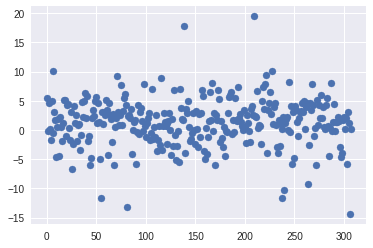

In [23]:

origin_airport_id = dataset[['ORIGIN_AIRPORT_ID']]
unique_airport_id = np.unique(origin_airport_id)
mean = []
for iden in unique_airport_id:
    d = dataset[['DEP_DELAY']].values[origin_airport_id == iden]
    mean.append(np.mean(d))
    
plt.scatter(range(0, len(mean)), mean)

On voit que certains des aéroports de départ observent un départ important. On peut essayer d'afficher les 10 pires aéroports:

In [27]:
mean = np.array(mean).astype(float)
for arg in np.argwhere(mean > 7):
    print(dataset[['ORIGIN']].values[unique_airport_id[arg] == origin_airport_id][0])


ACV
CSG
DAL
EWR
FLL
GGG
HOU
HYA
LAX
MIA
MVY
ORD
ORH
OTH
PGD
RDD
SFO
SWF


Et voilà! On fera attention la prochaine fois à ce que l'aéroport de départ ne se trouve pas dans cette liste.

On peut faire la même chose avec les aéroports d'arrivée.

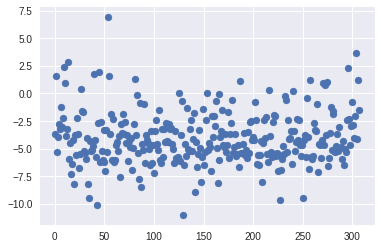

In [32]:
dest_airport_id = dataset[['DEST_AIRPORT_ID']]
unique_airport_id = np.unique(dest_airport_id)
mean = []
for iden in unique_airport_id:
    d = dataset[['ARR_DELAY']].values[dest_airport_id == iden] - dataset[['DEP_DELAY']].values[dest_airport_id == iden]
    mean.append(np.mean(d))
    
plt.scatter(range(0, len(mean)), mean)

In [34]:
mean = np.array(mean).astype(float)
for arg in np.argwhere(mean > 0):
    print(dataset[['DEST']].values[unique_airport_id[arg] == dest_airport_id][0])

ABI
ADK
ADQ
AKN
BET
BPT
BRW
CDC
CDV
DLG
ITO
MEI
OME
PSG
SAF
SGU
SIT
SJT
TWF
WYS
YAK


## Retard en fonction de l'heure

On peut également observé le retard en fonction de l'heure de départ et de l'heure d'arrivée

Text(0,0.5,'Retard moyen')

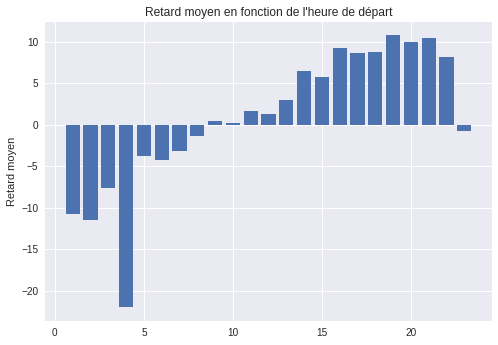

In [19]:
import matplotlib.pyplot as plt
import numpy as np
means=[]
dataset['CRS_DEP_TIME'] = dataset['CRS_DEP_TIME']/100
for i in range(0,24):
    means.append(dataset[['ARR_DELAY']][dataset['CRS_DEP_TIME'] == i].mean())
means = np.array(means).astype(float).reshape((24,))
plt.bar(np.array(range(0,24)), means)
plt.title('Retard moyen en fonction de l\'heure de départ')
plt.ylabel('Retard moyen')

Text(0,0.5,'Retard moyen')

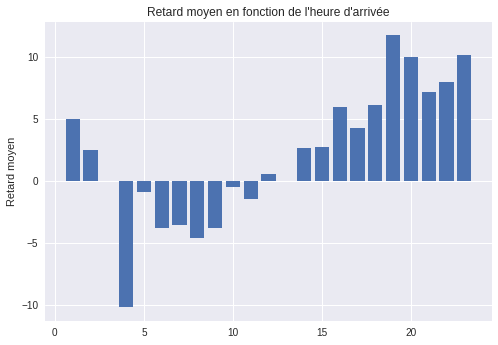

In [17]:
import matplotlib.pyplot as plt
import numpy as np
means=[]
dataset['CRS_ARR_TIME'] = dataset['CRS_ARR_TIME']/100
for i in range(0,24):
    means.append(dataset[['ARR_DELAY']][dataset['CRS_ARR_TIME'] == i].mean())
means = np.array(means).astype(float).reshape((24,))
plt.bar(np.array(range(0,24)), means)
plt.title('Retard moyen en fonction de l\'heure d\'arrivée')
plt.ylabel('Retard moyen')

On remarque clairement une accumulation du retard pendant la journée.

## Préparation du dataset

### Variables retenues

Nous n'allons pas retenir toutes les variables pour l'étude qui nous concerne. Nos variables sont : 

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562187 entries, 0 to 562186
Data columns (total 62 columns):
Unnamed: 0               562187 non-null int64
YEAR                     562187 non-null int64
QUARTER                  562187 non-null int64
MONTH                    562187 non-null int64
DAY_OF_MONTH             562187 non-null int64
DAY_OF_WEEK              562187 non-null int64
FL_DATE                  562187 non-null object
UNIQUE_CARRIER           562187 non-null object
AIRLINE_ID               562187 non-null int64
CARRIER                  562187 non-null object
TAIL_NUM                 560556 non-null object
FL_NUM                   562187 non-null int64
ORIGIN_AIRPORT_ID        562187 non-null int64
ORIGIN_AIRPORT_SEQ_ID    562187 non-null int64
ORIGIN_CITY_MARKET_ID    562187 non-null int64
ORIGIN                   562187 non-null object
ORIGIN_CITY_NAME         562187 non-null object
ORIGIN_STATE_ABR         562187 non-null object
ORIGIN_STATE_FIPS        562187 non-

Il faut que les informations soient disponibles à priori puisque nous cherchons à faire une prédiction. Les variables que nous retenons sont:

 + QUARTER
 + MONTH
 + DAY_OF_MONTH
 + DAY_OF_WEEK
 + UNIQUE_CARRIER
 + ORIGIN_AIRPORT_ID
 + DEST_AIRPORT_ID
 + CRS_DEP_TIME
 + CRS_ARR_TIME
 + ARR_DELAY
 + CANCELLED
 + DISTANCE
 

In [0]:
dataset = dataset[['QUARTER', 'MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DELAY','CANCELLED','DISTANCE']]


### Variables modifiées

On va modifier les variables de l'heure de départ et d'arrivée, pour ne retenir que l'heure et non pas la précision en minutes

In [0]:
 dataset[['CRS_DEP_TIME']] = (dataset[['CRS_DEP_TIME']]/100).astype(int)
 dataset[['CRS_ARR_TIME']] = (dataset[['CRS_ARR_TIME']]/100).astype(int)

### Création de variables

On a envie d'ajouter à ces variables, deux variables: le nombre de vols qui a lieu dans pendant l'heure de départ du vol dans le même aéroport et le nombre de vols qui arrivent dans l'heure d'arrivée dans le même aéroport. En effet, si il y a beaucoup d'arrivées au moment de l'atterrissage, on peut penser que le vol soit retardé (de même pour le décollage).

In [40]:
def create_nb_flight_arr_same_hour(d):
    nb_flight_arr_same_hour = np.ones((len(d),1))
    for iden in np.unique(d[['DEST_AIRPORT_ID']].values):
        arg1 = np.argwhere(reshape(d[['DEST_AIRPORT_ID']].values == iden))
        arg1 = reshape(arg1)
        d1 = d.iloc[arg1,:]
        for month in np.unique(d1[['MONTH']].values):
            arg2 = np.argwhere(reshape(d1[['MONTH']].values == month))
            arg2 = reshape(arg2)
            d2 = d1.iloc[arg2,:]
            for day in np.unique(d2[['DAY_OF_MONTH']].values):
                arg3 = np.argwhere(reshape(d2[['DAY_OF_MONTH']].values == day))
                arg3 = reshape(arg3)
                d3 = d2.iloc[arg3,:]
                for dep_time in  np.unique(d3[['CRS_ARR_TIME']]):
                    arg4 = np.argwhere(reshape(d3[['CRS_ARR_TIME']].values == dep_time))
                    arg4 = reshape(arg4)
                    arg = arg1[arg2[arg3[arg4]]]
                    nb_flight_arr_same_hour[arg] = len(arg)
    nb_flight_arr_same_hour = np.array(nb_flight_arr_same_hour).astype(int)
    NB_FLIGHT_ARR_SAME_HOUR = pd.DataFrame(nb_flight_arr_same_hour, index = d.index, columns = ['NB_FLIGHT_ARR_SAME_HOUR'])
    return NB_FLIGHT_ARR_SAME_HOUR

1012.885201


In [0]:
def create_nb_flight_dep_same_hour(d):
    nb_flight_dep_same_hour = np.ones((len(d),1))
    for iden in np.unique(d[['ORIGIN_AIRPORT_ID']].values):
        arg1 = np.argwhere(reshape(d[['ORIGIN_AIRPORT_ID']].values == iden))
        arg1 = reshape(arg1)
        d1 = d.iloc[arg1,:]
        for month in np.unique(d1[['MONTH']].values):
            arg2 = np.argwhere(reshape(d1[['MONTH']].values == month))
            arg2 = reshape(arg2)
            d2 = d1.iloc[arg2,:]
            for day in np.unique(d2[['DAY_OF_MONTH']].values):
                arg3 = np.argwhere(reshape(d2[['DAY_OF_MONTH']].values == day))
                arg3 = reshape(arg3)
                d3 = d2.iloc[arg3,:]
                for dep_time in  np.unique(d3[['CRS_DEP_TIME']]):
                    arg4 = np.argwhere(reshape(d3[['CRS_DEP_TIME']].values == dep_time))
                    arg4 = reshape(arg4)
                    arg = arg1[arg2[arg3[arg4]]]
                    nb_flight_dep_same_hour[arg] = len(arg)
    nb_flight_dep_same_hour = np.array(nb_flight_dep_same_hour).astype(int)
    NB_FLIGHT_DEP_SAME_HOUR = pd.DataFrame(nb_flight_dep_same_hour, index = d.index, columns = ['NB_FLIGHT_DEP_SAME_HOUR'])
    return NB_FLIGHT_DEP_SAME_HOUR

In [0]:
dataset = pd.concat([dataset, NB_FLIGHT_DEP_SAME_HOUR, NB_FLIGHT_ARR_SAME_HOUR])

### Traitement des valeurs manquantes

In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2810935 entries, 0 to 562186
Data columns (total 14 columns):
ARR_DELAY                  float64
CANCELLED                  float64
CRS_ARR_TIME               float64
CRS_DEP_TIME               float64
DAY_OF_MONTH               float64
DAY_OF_WEEK                float64
DEST_AIRPORT_ID            float64
DISTANCE                   float64
MONTH                      float64
NB_FLIGHT_ARR_SAME_HOUR    float64
NB_FLIGHT_DEP_SAME_HOUR    float64
ORIGIN_AIRPORT_ID          float64
QUARTER                    float64
UNIQUE_CARRIER             object
dtypes: float64(13), object(1)
memory usage: 321.7+ MB


On voit que le retard n'est pas connu dans certains cas, on va simplement supprimer les vols dont on ne connait pas le retard (ces vols ne pourraont pas  nous aider par la suite ni à apprendre notre modèle, ni à le valider).

In [0]:
dataset = dataset[~np.isnan(dataset[['ARR_DELAY']]).values]

## Traitement des variables

On peut effeectuer différents traitements, ici. On va devoir traiter les variables catégorielles dans un premier temps.

In [0]:
dataCG = dataset[['QUARTER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','CRS_DEP_TIME','CRS_ARR_TIME','CANCELLED']]

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
dataCG[['UNIQUE_CARRIER']] = labelencoder_X.fit_transform(dataCG[['UNIQUE_CARRIER']])
onehotencoder = OneHotEncoder()
dataCG = onehotencoder.fit_transform(dataCG).toarray()

On peut rassembler les données numériques et catégorielles.

In [0]:
dataset = pd.concat([dataCG, dataset['ARR_DELAY ','DISTANCE','NB_FLIGHT_ARR_SAME_HOUR', 'NB_FLIGHT_DEP_SAME_HOUR']])

## Conclusion

Nous avons observé nos données et sélectionnés soigneusement nos variables pour l'apprentissage de l'algorithme. Nous avons traités les valeurs manquantes, et les variables catégorielles. Nous avons également ajoutés deux variables qui nous paraissent intéressantes: le nombre de décollage qui a lieu dans l'heure du décollage considéré et le nombre d'atterissage qui a lieu au moment de l'aterrissage considéré.